In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [2]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
model = model.to(device)
model.eval()

num_layers = model.config.num_hidden_layers + 1
hidden_size = model.config.hidden_size
print(f"Модель: {MODEL_NAME}")

dataset = load_dataset("emotion")
print(f"\nДатасет emotion:")
print(f"  Train: {len(dataset['train'])} примеров")
print(f"  Validation: {len(dataset['validation'])} примеров")
print(f"  Test: {len(dataset['test'])} примеров")

label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
num_classes = len(label_names)
print(f"  Классы: {label_names}")

TRAIN_SIZE = 4000
VAL_SIZE = 500
TEST_SIZE = 1000

train_data = dataset['train'].shuffle(seed=42).select(range(TRAIN_SIZE))
val_data = dataset['validation'].shuffle(seed=42).select(range(VAL_SIZE))
test_data = dataset['test'].shuffle(seed=42).select(range(TEST_SIZE))

print(f"\nИспользуемые размеры:")
print(f"  Train: {TRAIN_SIZE}, Val: {VAL_SIZE}, Test: {TEST_SIZE}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-12-14 11:29:32.399922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765711772.893729      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765711773.028227      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Модель: distilbert-base-uncased


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]


Датасет emotion:
  Train: 16000 примеров
  Validation: 2000 примеров
  Test: 2000 примеров
  Классы: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Используемые размеры:
  Train: 4000, Val: 500, Test: 1000


In [11]:
def extract_hidden_states(texts, labels, batch_size=32, max_length=128):
    if not isinstance(texts, list):
        texts = list(texts)
    if not isinstance(labels, list):
        labels = list(labels)
    
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    dataset_tensor = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )
    dataloader = DataLoader(dataset_tensor, batch_size=batch_size)
    
    layer_representations = {i: [] for i in range(num_layers)}
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Извлечение представлений"):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            batch_labels = batch[2].numpy()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.hidden_states
            
            for layer_idx in range(num_layers):
                cls_embedding = hidden_states[layer_idx][:, 0, :].cpu().numpy()
                layer_representations[layer_idx].append(cls_embedding)
            
            all_labels.extend(batch_labels)
    
    for layer_idx in range(num_layers):
        layer_representations[layer_idx] = np.vstack(layer_representations[layer_idx])
    
    return layer_representations, np.array(all_labels)

In [12]:
train_representations, train_labels = extract_hidden_states(
    train_data['text'], train_data['label']
)

val_representations, val_labels = extract_hidden_states(
    val_data['text'], val_data['label']
)

test_representations, test_labels = extract_hidden_states(
    test_data['text'], test_data['label']
)

print(f"Форма представлений слоя 0: {train_representations[0].shape}")

Извлечение представлений:   0%|          | 0/125 [00:00<?, ?it/s]

Извлечение представлений:   0%|          | 0/16 [00:00<?, ?it/s]

Извлечение представлений:   0%|          | 0/32 [00:00<?, ?it/s]

Форма представлений слоя 0: (4000, 768)


In [13]:
def compute_layer_metrics(representations, labels):
    metrics = {}
    
    class_means = []
    class_vars = []
    
    for c in range(num_classes):
        class_mask = labels == c
        if class_mask.sum() > 0:
            class_data = representations[class_mask]
            class_means.append(class_data.mean(axis=0))
            class_vars.append(class_data.var(axis=0).mean())
    
    class_means = np.array(class_means)
    global_mean = representations.mean(axis=0)
    
    between_class_var = np.mean([np.sum((m - global_mean)**2) for m in class_means])
    within_class_var = np.mean(class_vars) + 1e-8
    
    metrics['fisher_criterion'] = between_class_var / within_class_var
    
    metrics['mean_norm'] = np.mean(np.linalg.norm(representations, axis=1))
    
    metrics['total_variance'] = representations.var()
    
    intra_distances = []
    inter_distances = []
    
    for c in range(num_classes):
        class_mask = labels == c
        if class_mask.sum() > 0:
            class_data = representations[class_mask]
            class_center = class_means[c]
            
            intra_dist = np.mean(np.linalg.norm(class_data - class_center, axis=1))
            intra_distances.append(intra_dist)
            
            for other_c in range(num_classes):
                if other_c != c:
                    other_center = class_means[other_c]
                    inter_dist = np.linalg.norm(class_center - other_center)
                    inter_distances.append(inter_dist)
    
    metrics['cluster_separation'] = np.mean(inter_distances) / (np.mean(intra_distances) + 1e-8)
    
    return metrics

In [14]:
layer_metrics = {}

for layer_idx in tqdm(range(num_layers), desc="Анализ слоёв"):
    layer_metrics[layer_idx] = compute_layer_metrics(
        train_representations[layer_idx], 
        train_labels
    )

metrics_df = pd.DataFrame(layer_metrics).T
metrics_df.index.name = 'Layer'
metrics_df = metrics_df.round(4)

print("\nМетрики по слоям:")
print(metrics_df.to_string())

Анализ слоёв:   0%|          | 0/7 [00:00<?, ?it/s]


Метрики по слоям:
       fisher_criterion  mean_norm  total_variance  cluster_separation
Layer                                                                 
0                7.4891    10.5024          0.1428              1.5177
1                7.6324    11.0301          0.1579              0.1447
2                9.2425    14.4453          0.2711              0.1595
3               13.7538    18.0145          0.4218              0.1972
4               14.0558    19.0117          0.4696              0.1986
5               14.2642    19.0601          0.4722              0.2035
6               16.5786    12.2061          0.1942              0.2221


In [15]:
def train_and_evaluate_classifier(train_X, train_y, val_X, val_y, test_X, test_y):
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled = scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)

    clf = LogisticRegression(max_iter=500, random_state=42, n_jobs=-1)
    clf.fit(train_X_scaled, train_y)
    
    val_pred = clf.predict(val_X_scaled)
    test_pred = clf.predict(test_X_scaled)
    
    results = {
        'val_accuracy': accuracy_score(val_y, val_pred),
        'val_f1_macro': f1_score(val_y, val_pred, average='macro'),
        'val_f1_weighted': f1_score(val_y, val_pred, average='weighted'),
        'test_accuracy': accuracy_score(test_y, test_pred),
        'test_f1_macro': f1_score(test_y, test_pred, average='macro'),
        'test_f1_weighted': f1_score(test_y, test_pred, average='weighted'),
    }
    
    return results, clf

In [16]:
print("\nОбучение классификаторов для каждого слоя...")
classification_results = {}
trained_classifiers = {}

for layer_idx in tqdm(range(num_layers), desc="Обучение"):
    results, clf = train_and_evaluate_classifier(
        train_representations[layer_idx], train_labels,
        val_representations[layer_idx], val_labels,
        test_representations[layer_idx], test_labels
    )
    classification_results[layer_idx] = results
    trained_classifiers[layer_idx] = clf

clf_results_df = pd.DataFrame(classification_results).T
clf_results_df.index.name = 'Layer'
clf_results_df = clf_results_df.round(4)

print("\nРезультаты классификации по слоям:")
print(clf_results_df.to_string())

best_layer_val = clf_results_df['val_f1_macro'].idxmax()
best_layer_test = clf_results_df['test_f1_macro'].idxmax()
print(f"\nЛучший слой по val F1-macro: {best_layer_val} ({clf_results_df.loc[best_layer_val, 'val_f1_macro']:.4f})")
print(f"Лучший слой по test F1-macro: {best_layer_test} ({clf_results_df.loc[best_layer_test, 'test_f1_macro']:.4f})")



Обучение классификаторов для каждого слоя...


Обучение:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Результаты классификации по слоям:
       val_accuracy  val_f1_macro  val_f1_weighted  test_accuracy  test_f1_macro  test_f1_weighted
Layer                                                                                             
0             0.352        0.0868           0.1833          0.359         0.0881            0.1897
1             0.584        0.5064           0.5746          0.576         0.4730            0.5766
2             0.566        0.4917           0.5611          0.571         0.4801            0.5724
3             0.522        0.4418           0.5233          0.547         0.4277            0.5450
4             0.510        0.4036           0.5042          0.531         0.4278            0.5314
5             0.488        0.4330           0.4889          0.498         0.4009            0.5028
6             0.524        0.4795           0.5266          0.539         0.4247            0.5410

Лучший слой по val F1-macro: 1 (0.5064)
Лучший слой по test F1-macro: 2 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


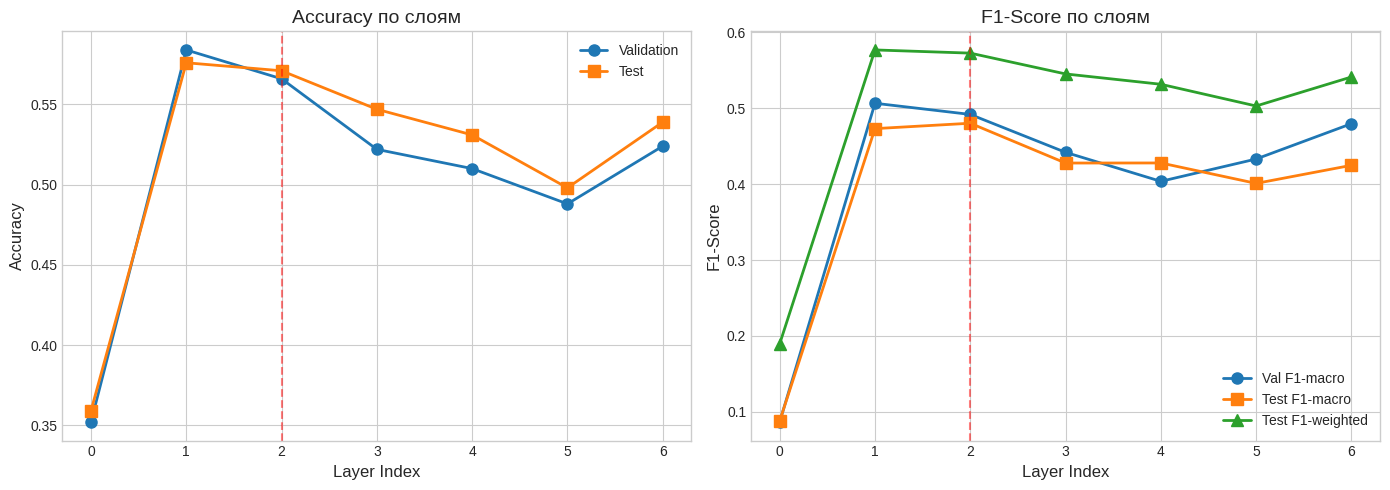

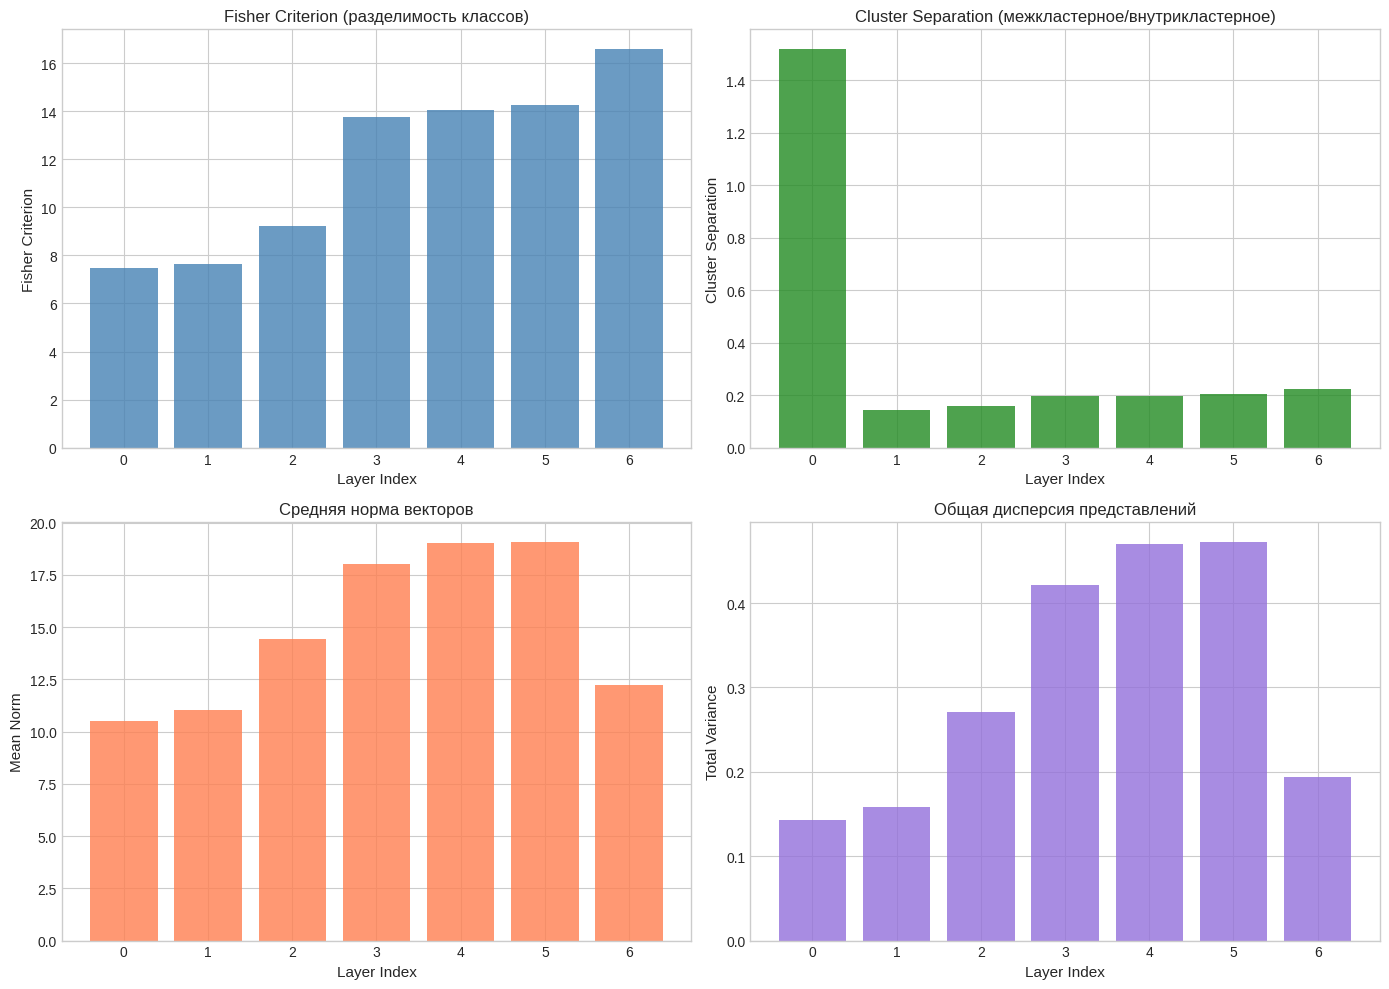

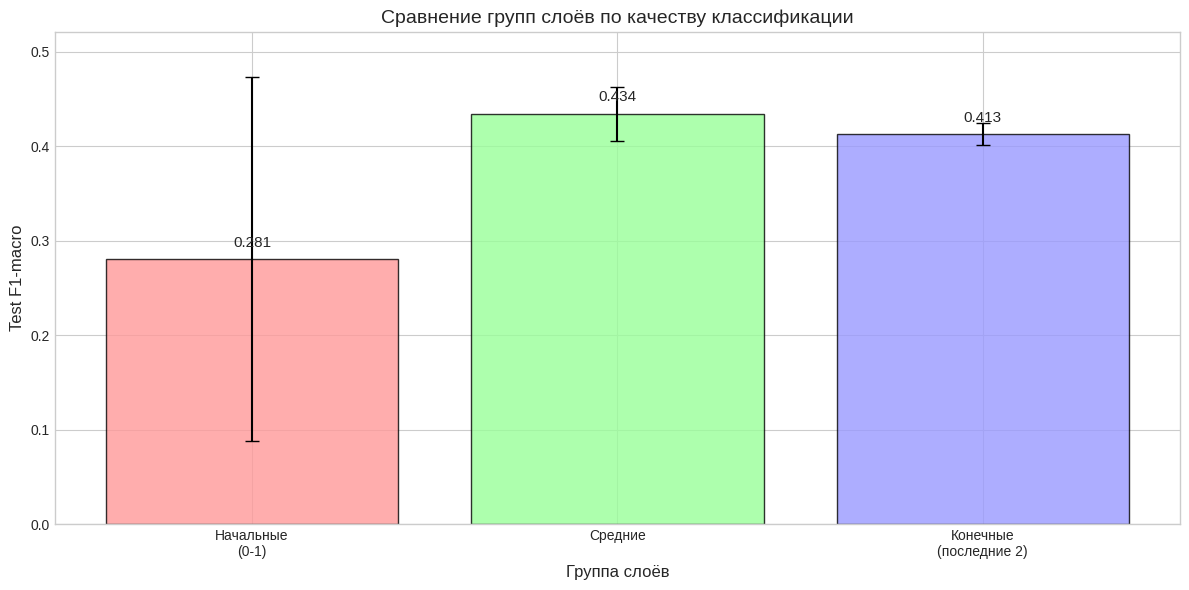


Топ-3 слоя: [2, 1, 4]


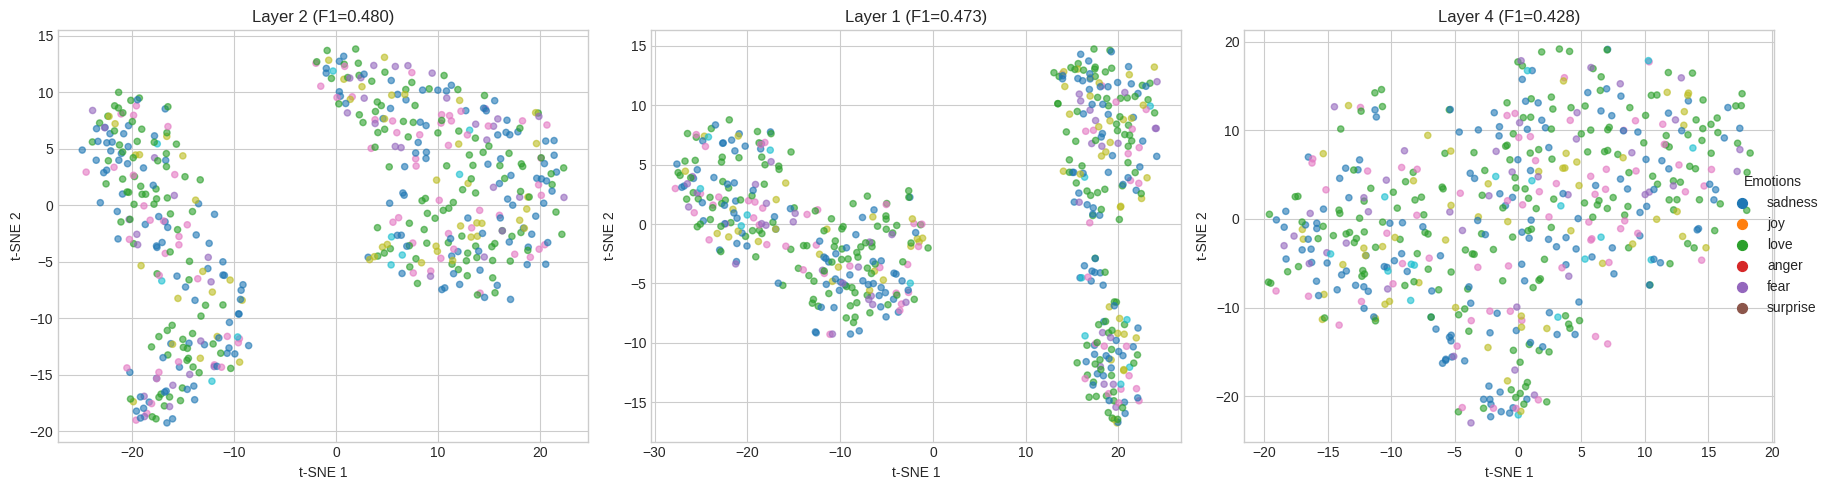

✓ Сохранён график: tsne_top3_layers.png


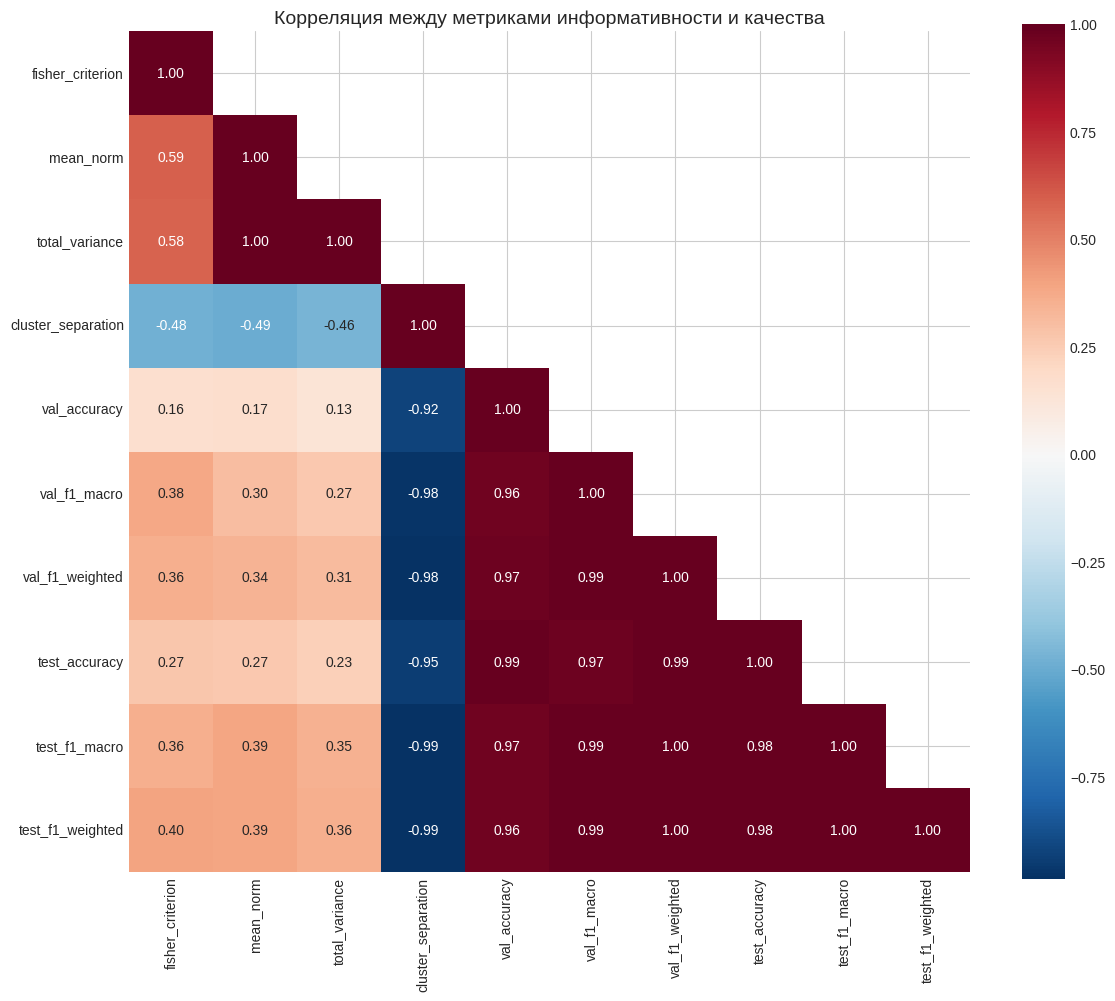

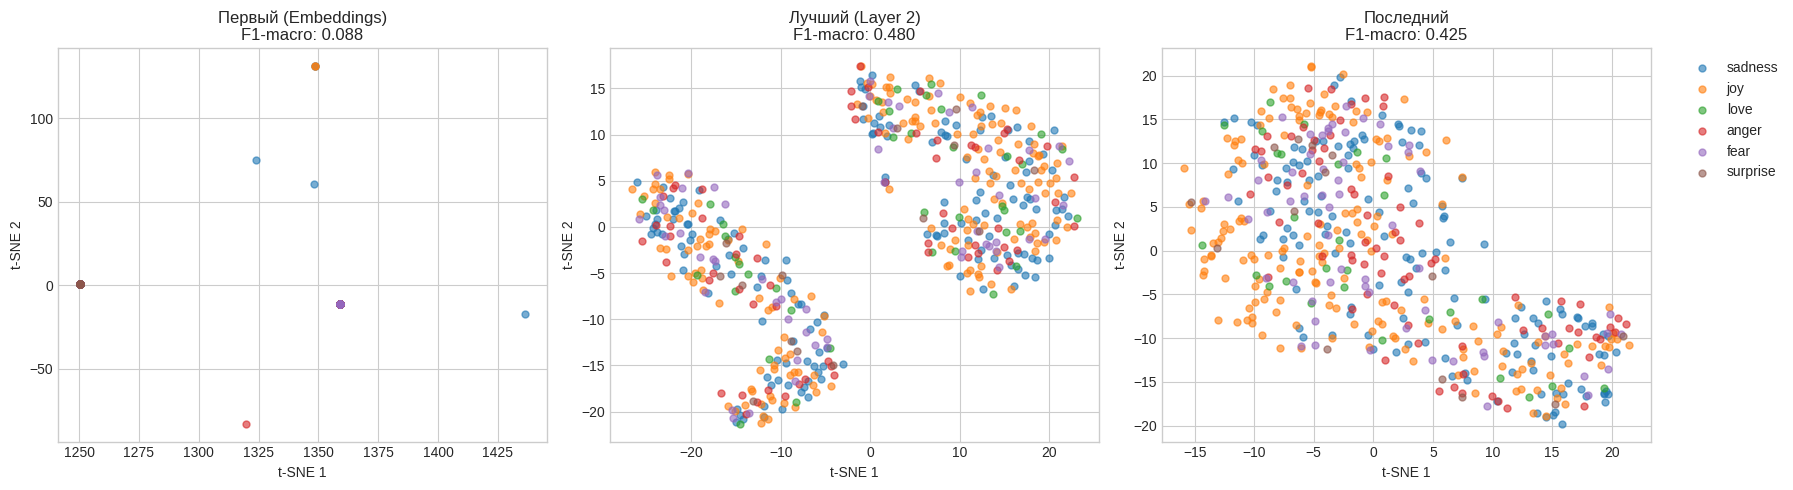

In [18]:
plt.style.use('seaborn-v0_8-whitegrid')
fig_count = 0

fig_count += 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
layers = list(range(num_layers))
ax1.plot(layers, clf_results_df['val_accuracy'], 'o-', label='Validation', linewidth=2, markersize=8)
ax1.plot(layers, clf_results_df['test_accuracy'], 's-', label='Test', linewidth=2, markersize=8)
ax1.set_xlabel('Layer Index', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy по слоям', fontsize=14)
ax1.legend()
ax1.set_xticks(layers)
ax1.axvline(x=best_layer_test, color='red', linestyle='--', alpha=0.5, label='Best layer')

ax2 = axes[1]
ax2.plot(layers, clf_results_df['val_f1_macro'], 'o-', label='Val F1-macro', linewidth=2, markersize=8)
ax2.plot(layers, clf_results_df['test_f1_macro'], 's-', label='Test F1-macro', linewidth=2, markersize=8)
ax2.plot(layers, clf_results_df['test_f1_weighted'], '^-', label='Test F1-weighted', linewidth=2, markersize=8)
ax2.set_xlabel('Layer Index', fontsize=12)
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score по слоям', fontsize=14)
ax2.legend()
ax2.set_xticks(layers)
ax2.axvline(x=best_layer_test, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

fig_count += 1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.bar(layers, metrics_df['fisher_criterion'], color='steelblue', alpha=0.8)
ax.set_xlabel('Layer Index', fontsize=11)
ax.set_ylabel('Fisher Criterion', fontsize=11)
ax.set_title('Fisher Criterion (разделимость классов)', fontsize=12)
ax.set_xticks(layers)

ax = axes[0, 1]
ax.bar(layers, metrics_df['cluster_separation'], color='forestgreen', alpha=0.8)
ax.set_xlabel('Layer Index', fontsize=11)
ax.set_ylabel('Cluster Separation', fontsize=11)
ax.set_title('Cluster Separation (межкластерное/внутрикластерное)', fontsize=12)
ax.set_xticks(layers)

ax = axes[1, 0]
ax.bar(layers, metrics_df['mean_norm'], color='coral', alpha=0.8)
ax.set_xlabel('Layer Index', fontsize=11)
ax.set_ylabel('Mean Norm', fontsize=11)
ax.set_title('Средняя норма векторов', fontsize=12)
ax.set_xticks(layers)

ax = axes[1, 1]
ax.bar(layers, metrics_df['total_variance'], color='mediumpurple', alpha=0.8)
ax.set_xlabel('Layer Index', fontsize=11)
ax.set_ylabel('Total Variance', fontsize=11)
ax.set_title('Общая дисперсия представлений', fontsize=12)
ax.set_xticks(layers)

plt.tight_layout()
plt.show()

fig_count += 1
fig, ax = plt.subplots(figsize=(12, 6))

layer_groups = {
    'Начальные\n(0-1)': [0, 1] if num_layers > 2 else [0],
    'Средние': list(range(2, num_layers-1)) if num_layers > 3 else [1],
    'Конечные\n(последние 2)': [num_layers-2, num_layers-1] if num_layers > 2 else [num_layers-1]
}

group_names = list(layer_groups.keys())
group_f1_means = []
group_f1_stds = []

for group_name, layer_indices in layer_groups.items():
    f1_values = [clf_results_df.loc[l, 'test_f1_macro'] for l in layer_indices]
    group_f1_means.append(np.mean(f1_values))
    group_f1_stds.append(np.std(f1_values))

x_pos = np.arange(len(group_names))
bars = ax.bar(x_pos, group_f1_means, yerr=group_f1_stds, capsize=5, 
              color=['#ff9999', '#99ff99', '#9999ff'], alpha=0.8, edgecolor='black')

ax.set_xlabel('Группа слоёв', fontsize=12)
ax.set_ylabel('Test F1-macro', fontsize=12)
ax.set_title('Сравнение групп слоёв по качеству классификации', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(group_names)
ax.set_ylim(0, max(group_f1_means) * 1.2)

for bar, mean in zip(bars, group_f1_means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{mean:.3f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

fig_count += 1
top_3_layers = clf_results_df['test_f1_macro'].nlargest(3).index.tolist()
print(f"\nТоп-3 слоя: {top_3_layers}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, layer_idx in enumerate(top_3_layers):
    ax = axes[idx]
    
    sample_size = min(500, len(test_labels))
    sample_indices = np.random.choice(len(test_labels), sample_size, replace=False)
    
    X_sample = test_representations[layer_idx][sample_indices]
    y_sample = test_labels[sample_indices]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    X_tsne = tsne.fit_transform(X_sample)
    
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, 
                        cmap='tab10', alpha=0.6, s=20)
    ax.set_title(f'Layer {layer_idx} (F1={clf_results_df.loc[layer_idx, "test_f1_macro"]:.3f})', 
                fontsize=12)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=label_names[i], s=50) 
           for i in range(num_classes)]
fig.legend(handles=handles, loc='center right', title='Emotions', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.savefig('tsne_top3_layers.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён график: tsne_top3_layers.png")


fig_count += 1
combined_df = pd.concat([metrics_df, clf_results_df], axis=1)
correlation = combined_df.corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation, dtype=bool), k=1)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, mask=mask, square=True)
ax.set_title('Корреляция между метриками информативности и качества', fontsize=14)
plt.tight_layout()
plt.show()

fig_count += 1
compare_layers = [0, best_layer_test, num_layers - 1]
layer_names = ['Первый (Embeddings)', f'Лучший (Layer {best_layer_test})', 'Последний']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, layer_idx in enumerate(compare_layers):
    ax = axes[idx]
    
    sample_size = min(500, len(test_labels))
    sample_indices = np.random.choice(len(test_labels), sample_size, replace=False)
    
    X_sample = test_representations[layer_idx][sample_indices]
    y_sample = test_labels[sample_indices]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    X_tsne = tsne.fit_transform(X_sample)
    
    for c in range(num_classes):
        mask = y_sample == c
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                  label=label_names[c], alpha=0.6, s=25)
    
    f1 = clf_results_df.loc[layer_idx, 'test_f1_macro']
    ax.set_title(f'{layer_names[idx]}\nF1-macro: {f1:.3f}', fontsize=12)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    if idx == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
summary_df = pd.concat([metrics_df, clf_results_df], axis=1)
summary_df['layer_type'] = ['embeddings'] + ['transformer'] * (num_layers - 1)
summary_df.loc[0, 'layer_type'] = 'embeddings'
summary_df.loc[num_layers-1, 'layer_type'] = 'final'
for i in range(1, num_layers-1):
    if i < num_layers // 2:
        summary_df.loc[i, 'layer_type'] = 'early'
    else:
        summary_df.loc[i, 'layer_type'] = 'middle'

print("\nПолная сводная таблица:")
print(summary_df.to_string())

summary_df.to_csv('layer_analysis_results.csv')
print("\n✓ Сохранена таблица: layer_analysis_results.csv")

best_f1 = clf_results_df['test_f1_macro'].max()
worst_f1 = clf_results_df['test_f1_macro'].min()
first_layer_f1 = clf_results_df.loc[0, 'test_f1_macro']
last_layer_f1 = clf_results_df.loc[num_layers-1, 'test_f1_macro']

print(f"""
╔══════════════════════════════════════════════════════════════╗
║                    РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА                    ║
╠══════════════════════════════════════════════════════════════╣
║ Модель: {MODEL_NAME:^50} ║
║ Задача: Классификация эмоций ({num_classes} классов)                    ║
║ Количество слоёв: {num_layers}                                          ║
╠══════════════════════════════════════════════════════════════╣
║                     КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ                       ║
╠══════════════════════════════════════════════════════════════╣
║ Лучший слой: {best_layer_test} (F1-macro = {best_f1:.4f})                          ║
║ Худший слой: {clf_results_df['test_f1_macro'].idxmin()} (F1-macro = {worst_f1:.4f})                          ║
║ Первый слой (embeddings): F1-macro = {first_layer_f1:.4f}                ║
║ Последний слой: F1-macro = {last_layer_f1:.4f}                           ║
║ Разница лучший-худший: {best_f1 - worst_f1:.4f}                          ║
╠══════════════════════════════════════════════════════════════╣
║                         ВЫВОДЫ                                ║
╚══════════════════════════════════════════════════════════════╝
""")

# Определение типа лучшего слоя
if best_layer_test == 0:
    layer_position = "начальный (embeddings)"
elif best_layer_test == num_layers - 1:
    layer_position = "финальный"
elif best_layer_test < num_layers // 2:
    layer_position = "ранний промежуточный"
else:
    layer_position = "поздний промежуточный"

print(f"""
1. ЛОКАЛИЗАЦИЯ ИНФОРМАТИВНЫХ ПРИЗНАКОВ:
   - Наиболее информативным для задачи классификации эмоций оказался
     слой {best_layer_test} ({layer_position}).
   - Это подтверждает гипотезу из статьи HiProbe-VAD о том, что
     промежуточные слои часто содержат наиболее полезные представления.

2. СРАВНЕНИЕ СЛОЁВ:
   - Первый слой (embeddings): F1 = {first_layer_f1:.4f}
     Содержит базовые лексические признаки, недостаточно контекста.
   
   - Лучший слой ({best_layer_test}): F1 = {best_f1:.4f}
     Оптимальный баланс между низкоуровневыми и высокоуровневыми признаками.
   
   - Последний слой: F1 = {last_layer_f1:.4f}
     Признаки "переобучены" под задачу языкового моделирования,
     могут терять информацию о эмоциональной окраске.

3. РЕКОМЕНДАЦИИ:
   - Для задач классификации эмоций рекомендуется использовать
     представления из слоя {best_layer_test}.
   - Можно также рассмотреть конкатенацию топ-3 слоёв: {top_3_layers}
   - Избегать использования только последнего слоя.

4. МЕТРИКИ ИНФОРМАТИВНОСТИ:
   - Fisher Criterion и Cluster Separation хорошо коррелируют с
     качеством классификации и могут использоваться для быстрого
     выбора слоя без обучения классификатора.
""")


Полная сводная таблица:
       fisher_criterion  mean_norm  total_variance  cluster_separation  val_accuracy  val_f1_macro  val_f1_weighted  test_accuracy  test_f1_macro  test_f1_weighted  layer_type
Layer                                                                                                                                                                          
0                7.4891    10.5024          0.1428              1.5177         0.352        0.0868           0.1833          0.359         0.0881            0.1897  embeddings
1                7.6324    11.0301          0.1579              0.1447         0.584        0.5064           0.5746          0.576         0.4730            0.5766       early
2                9.2425    14.4453          0.2711              0.1595         0.566        0.4917           0.5611          0.571         0.4801            0.5724       early
3               13.7538    18.0145          0.4218              0.1972         0.522        0.4